In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os, os.path
import glob
import pickle
import numpy
from tqdm import tqdm
from scipy import special, integrate
numpy.random.seed(1)
from scipy import optimize
import bovy_mcmc
import emcee
from galpy import potential
from galpy.util import bovy_plot, save_pickles, bovy_conversion

import corner
import matplotlib as plt
from matplotlib.ticker import NullFormatter
from matplotlib import gridspec, cm
%pylab inline

import functools

import sys; sys.path.insert(0, '../')
from src import MWPotential2014Likelihood
_REFR0, _REFV0= MWPotential2014Likelihood._REFR0, MWPotential2014Likelihood._REFV0
save_figures= False
# Read the necessary data
#First read the surface densities
surffile= '../data/mwpot14data/bovyrix13kzdata.csv'
if not surffile is None and os.path.exists(surffile):
    surf= numpy.loadtxt(surffile,delimiter=',')
    surfrs= surf[:,2]
    kzs= surf[:,6]
    kzerrs= surf[:,7]
# Then the terminal velocities
cl_glon, cl_vterm, cl_corr= MWPotential2014Likelihood.readClemens(dsinl=0.125)
mc_glon, mc_vterm, mc_corr= MWPotential2014Likelihood.readMcClureGriffiths(dsinl=0.125)
mc16_glon, mc16_vterm, mc16_corr= MWPotential2014Likelihood.readMcClureGriffiths16(dsinl=0.125)
termdata= (cl_glon,cl_vterm,cl_corr,
           mc_glon,mc_vterm,mc_corr)
termdata_mc16= (mc16_glon,mc16_vterm,mc16_corr,
                mc_glon,mc_vterm,mc_corr)

Populating the interactive namespace from numpy and matplotlib
/home/nstarkman/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"

/home/nstarkman/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/nstarkman/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



# MWPotential2014 constraints with variable halo flattening

In [3]:
@functools.lru_cache(maxsize=32)
def fit(fitc=False,ro=_REFR0,vo=_REFV0,fitvoro=False,c=1.,dblexp=False,plots=True,
        addpal5=False,addgd1=False,mc16=False,addgas=False):
    init_params= [0.5,0.45,numpy.log(2.5/8.),numpy.log(0.4/8.),
                  numpy.log(20./8.),0.,0.]
    if fitvoro:
        init_params.extend([1.,1.])
    if fitc:
        init_params.append(1.)
    if mc16:
        funcargs= (c,surfrs,kzs,kzerrs,termdata_mc16,7.,fitc,fitvoro,dblexp,addpal5,addgd1,ro,vo,addgas)
    else:
        funcargs= (c,surfrs,kzs,kzerrs,termdata,7.,fitc,fitvoro,dblexp,addpal5,addgd1,ro,vo,addgas)
    params= optimize.fmin_powell(MWPotential2014Likelihood.like_func,
                                 init_params,args=funcargs,disp=False)
    if plots:
        fig = plt.Figure()
        if fitvoro:
            ro, vo= _REFR0*params[8],_REFV0*params[7]
        pot= MWPotential2014Likelihood.setup_potential(params,c,fitc,dblexp,ro,vo,fitvoro=fitvoro)
        subplot(1,3,1)
        MWPotential2014Likelihood.plotRotcurve(pot)
        subplot(1,3,2)
        MWPotential2014Likelihood.plotKz(pot,surfrs,kzs,kzerrs,ro,vo)
        subplot(1,3,3)
        if mc16: MWPotential2014Likelihood.plotTerm(pot,termdata_mc16,ro,vo)
        else: MWPotential2014Likelihood.plotTerm(pot,termdata,ro,vo)
        tight_layout()
    return (params,MWPotential2014Likelihood.like_func(params,*funcargs))

In [4]:
# @functools.lru_cache(maxsize=32)
def sample(nsamples=1000,params=None,fitc=False,ro=_REFR0,vo=_REFV0,fitvoro=False,c=1.,
           dblexp=False,addpal5=False,addgd1=False,plots=True,mc16=False,addgas=False,
           _use_emcee=True):
    if params is None:
        params= fit(fitc=fitc,ro=ro,vo=vo,fitvoro=fitvoro,c=c,
                    dblexp=dblexp,plots=False,addpal5=addpal5,addgd1=addgd1,addgas=addgas)[0]
    if mc16:
        funcargs= (c,surfrs,kzs,kzerrs,termdata_mc16,7.,fitc,fitvoro,dblexp,addpal5,addgd1,ro,vo,addgas)
    else:
        funcargs= (c,surfrs,kzs,kzerrs,termdata,7.,fitc,fitvoro,dblexp,addpal5,addgd1,ro,vo,addgas)
    samples=\
        bovy_mcmc.markovpy(params,0.2,
                           lambda x: -MWPotential2014Likelihood.like_func(x,*funcargs),(),
                           isDomainFinite=[[False,False] for ii in range(len(params))],
                           domain= [[0.,0.] for ii in range(len(params))],
                           nsamples=nsamples,
                           nwalkers=2*len(params),
                           _use_emcee=_use_emcee
                          )
    samples= numpy.array(samples).T
    if plots: plot_samples(samples,fitc,ro=ro,vo=vo)
    return samples

def sample_multi(nsamples=1000,params=None,fitc=False,ro=_REFR0,vo=_REFV0,fitvoro=False,c=1.,
                 dblexp=False,addpal5=False,addgd1=False,plots=True,mc16=False,addgas=False):
    if params is None:
        params= fit(fitc=fitc,ro=ro,vo=vo,fitvoro=fitvoro,c=c,
                    dblexp=dblexp,plots=False,addpal5=addpal5,addgd1=addgd1,addgas=addgas)[0]
    if mc16:
        funcargs= (c,surfrs,kzs,kzerrs,termdata_mc16,7.,fitc,fitvoro,dblexp,addpal5,addgd1,ro,vo,addgas)
    else:
        funcargs= (c,surfrs,kzs,kzerrs,termdata,7.,fitc,fitvoro,dblexp,addpal5,addgd1,ro,vo,addgas)
    nwalkers= 2*len(params)
    nn= 0
    all_start_params= numpy.zeros((nwalkers,len(params)))
    start_lnprob0= numpy.zeros(nwalkers)
    step= 0.05*numpy.ones(len(params))
    while nn < nwalkers:
        all_start_params[nn]= params\
            +numpy.random.normal(size=len(params))*step
        start_lnprob0[nn]= MWPotential2014Likelihood.pdf_func(all_start_params[nn],*funcargs)
        if start_lnprob0[nn] > -1000000.: nn+= 1
    sampler= emcee.EnsembleSampler(nwalkers,len(params),
                                   MWPotential2014Likelihood.pdf_func,args=funcargs,
                                   threads=len(params))
    rstate0= numpy.random.mtrand.RandomState().get_state()
    out= numpy.zeros((len(params),nsamples))
    for ii in tqdm(range(nsamples//(10*nwalkers))): # burn-in
        new_params, new_lnp, new_rstate0=\
            sampler.run_mcmc(all_start_params,1,lnprob0=start_lnprob0,
                             rstate0=rstate0,storechain=False)
        all_start_params= new_params
        start_lnprob0= new_lnp
        rstate0= new_rstate0
    for ii in tqdm(range(nsamples//nwalkers+1)): # burn-in
        new_params, new_lnp, new_rstate0=\
            sampler.run_mcmc(all_start_params,1,lnprob0=start_lnprob0,
                             rstate0=rstate0,storechain=False)
        all_start_params= new_params
        start_lnprob0= new_lnp
        rstate0= new_rstate0
        nleft= nsamples-ii*nwalkers
        if nleft < nwalkers:
            out[:,ii*nwalkers:]= new_params.T[:,:nleft]
        else:
            out[:,ii*nwalkers:(ii+1)*nwalkers]= new_params.T
    samples= out
    if plots: plot_samples(samples,fitc,ro=ro,vo=vo)
    return samples
def plot_samples(samples,fitc,fitvoro,addpal5=False,addgd1=False,ro=_REFR0,vo=_REFV0,):
    labels= [r'$f_d$',r'$f_h$',r'$h_R / \mathrm{kpc}$',r'$h_z / \mathrm{pc}$',
             r'$r_s / \mathrm{kpc}$']
    ranges= [(0.,1.),(0.,1.),(2.,4.49),(150.,445.),(0.,39.)]
    if fitvoro:
        labels.extend([r'$R_0 / \mathrm{kpc}$',
                       r'$V_c(R_0) / \mathrm{km\,s}^{-1}$'])
        ranges.extend([(7.,8.7),(200.,240.)])
    if fitc: 
        labels.append(r'$c/a$')
        if addpal5 or addgd1:
            ranges.append((0.5,1.5))
        else:
            ranges.append((0.,4.))
    subset= numpy.ones(len(samples),dtype='bool')
    subset[5:7]= False
    plotsamples= samples[subset]
    plotsamples[2]= numpy.exp(samples[2])*ro
    plotsamples[3]= numpy.exp(samples[3])*1000.*ro
    plotsamples[4]= numpy.exp(samples[4])*ro
    if fitvoro:
        plotsamples[5]= samples[7]*ro
        plotsamples[6]= samples[8]*vo
    corner.corner(plotsamples.T,quantiles=[0.16, 0.5, 0.84],labels=labels,
                  show_titles=True, title_args={"fontsize": 12},range=ranges)

In [5]:
def plot_mcmc_c(samples,fitvoro,add_families=False):
    if add_families:
        st0= numpy.random.get_state()
        numpy.random.seed(1)
        with open('mwpot14varyc-samples.pkl','rb') as savefile:
            pot_samples= pickle.load(savefile)
        rndindices= numpy.random.permutation(pot_samples.shape[1])
        pot_params= numpy.zeros((8,32))
        for ii in range(32):
            pot_params[:,ii]= pot_samples[:,rndindices[ii]]
    if fitvoro:
        cindx= 9
    else:
        cindx= 7
    cmap= cm.viridis
    levels= list(special.erf(numpy.arange(1,3)/numpy.sqrt(2.)))
    levels.append(1.01)
    def axes_white():
        for k, spine in gca().spines.items():  #ax.spines is a dictionary
            spine.set_color('w')
        gca().tick_params(axis='x',which='both',colors='w')
        gca().tick_params(axis='y',which='both',colors='w')
        [t.set_color('k') for t in gca().xaxis.get_ticklabels()]
        [t.set_color('k') for t in gca().yaxis.get_ticklabels()]
        return None
    figsize(16+2*fitvoro,4)
    gs=  gridspec.GridSpec(1,5+2*fitvoro,wspace=0.015)
    subplot(gs[0])
    bovy_plot.scatterplot(samples[0],samples[cindx],',',
                          gcf=True,bins=31,cmap=cmap,cntrcolors='0.6',
                         xrange=[0.,.99],yrange=[0.,4.],levels=levels,
                         xlabel=r'$f_d$',ylabel=r'$c/a$',zorder=1)
    bovy_plot.bovy_plot([bp[0] for bp in bf_params],cs,'w-',overplot=True)
    if add_families:
        fm_kw= {'color':'w','marker':'x','ls':'none','ms':4.,'mew':1.2}
        bovy_plot.bovy_plot(pot_params[0],pot_params[7],overplot=True,**fm_kw)
    axes_white()
    subplot(gs[1])
    bovy_plot.scatterplot(samples[1],samples[cindx],',',
                          gcf=True,bins=31,cmap=cmap,cntrcolors='0.6',
                         xrange=[0.,.99],yrange=[0.,4.],levels=levels,
                         xlabel=r'$f_h$')
    bovy_plot.bovy_plot([bp[1] for bp in bf_params],cs,'w-',overplot=True)
    if add_families:
        bovy_plot.bovy_plot(pot_params[1],pot_params[7],overplot=True,**fm_kw)
    nullfmt= NullFormatter()
    gca().yaxis.set_major_formatter(nullfmt)
    axes_white()
    subplot(gs[2])
    bovy_plot.scatterplot(numpy.exp(samples[2])*_REFR0,samples[cindx],',',
                          gcf=True,bins=21,levels=levels,
                         xrange=[2.,4.49],yrange=[0.,4.],cmap=cmap,cntrcolors='0.6',
                         xlabel=r'$h_R\,(\mathrm{kpc})$')
    bovy_plot.bovy_plot([numpy.exp(bp[2])*_REFR0 for bp in bf_params],cs,'w-',overplot=True)
    if add_families:
        bovy_plot.bovy_plot(numpy.exp(pot_params[2])*_REFR0,pot_params[7],overplot=True,**fm_kw)
    nullfmt= NullFormatter()
    gca().yaxis.set_major_formatter(nullfmt)
    axes_white()
    subplot(gs[3])
    bovy_plot.scatterplot(numpy.exp(samples[3])*_REFR0*1000.,samples[cindx],',',
                          gcf=True,bins=26,levels=levels,
                         xrange=[150.,445.],yrange=[0.,4.],cmap=cmap,cntrcolors='0.6',
                         xlabel=r'$h_z\,(\mathrm{pc})$')
    bovy_plot.bovy_plot([numpy.exp(bp[3])*_REFR0*1000. for bp in bf_params],cs,'w-',overplot=True)
    if add_families:
        bovy_plot.bovy_plot(numpy.exp(pot_params[3])*_REFR0*1000.,pot_params[7],overplot=True,**fm_kw)
    nullfmt= NullFormatter()
    gca().yaxis.set_major_formatter(nullfmt)
    gca().xaxis.set_ticks([200.,300.,400.])
    axes_white()
    subplot(gs[4])
    bovy_plot.scatterplot(numpy.exp(samples[4])*_REFR0,samples[cindx],',',
                          gcf=True,bins=26,levels=levels,
                         xrange=[0.,39.],yrange=[0.,4.],cmap=cmap,cntrcolors='0.6',
                         xlabel=r'$r_s\,(\mathrm{kpc})$')
    bovy_plot.bovy_plot([numpy.exp(bp[4])*_REFR0 for bp in bf_params],cs,'w-',overplot=True)
    if add_families:
        bovy_plot.bovy_plot(numpy.exp(pot_params[4])*_REFR0,pot_params[7],overplot=True,**fm_kw)
    nullfmt= NullFormatter()
    gca().yaxis.set_major_formatter(nullfmt)
    axes_white()
    if not fitvoro: return None
    subplot(gs[5])
    bovy_plot.scatterplot(samples[7]*_REFR0,samples[cindx],',',
                          gcf=True,bins=26,levels=levels,
                         xrange=[7.1,8.9],yrange=[0.,4.],cmap=cmap,cntrcolors='0.6',
                         xlabel=r'$R_0\,(\mathrm{kpc})$')
    nullfmt= NullFormatter()
    gca().yaxis.set_major_formatter(nullfmt)
    axes_white()
    subplot(gs[6])
    bovy_plot.scatterplot(samples[8]*_REFV0,samples[cindx],',',
                          gcf=True,bins=26,levels=levels,
                         xrange=[200.,250.],yrange=[0.,4.],cmap=cmap,cntrcolors='0.6',
                         xlabel=r'$V_c(R_0)\,(\mathrm{km\,s}^{-1})$')
    nullfmt= NullFormatter()
    gca().yaxis.set_major_formatter(nullfmt)
    axes_white()
    return None

## Basic, Bovy (2015) fit with $c=1$

Using the Clemens CO terminal-velocity data:

/home/nstarkman/miniconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1977: RuntimeWarning: overflow encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)



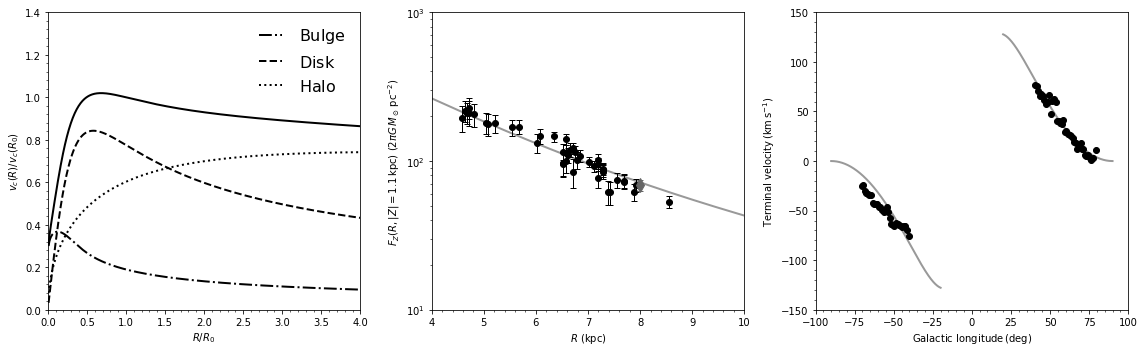

In [6]:
figsize(16,5)
p_b15= fit(fitc=False,c=1.)

Best-fit parameters and minus log likelihood:

In [7]:
print(p_b15)

(array([ 0.60099328,  0.3629447 , -0.97598817, -3.34180914,  0.71768812,
       -0.01519319, -0.01928603]), 144.1697671844393)


Using the McClure-Griffiths & Dickey HI terminal-velocity data instead:

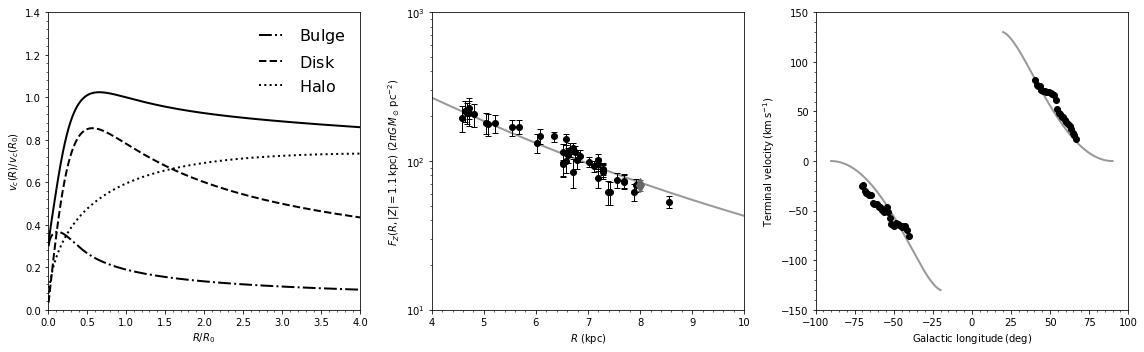

In [8]:
figsize(16,5)
p_b15_mc16= fit(fitc=False,c=1.,mc16=True)

We ran the initial analysis with Clemens, which we keep here, until we start interpreting the Pal 5 and GD-1 data; then we switch to the McClure-Griffths & Dickey data. The resulting best-fit parameters here are almost the same, well within each others errors.

## Fits with $c\neq1$

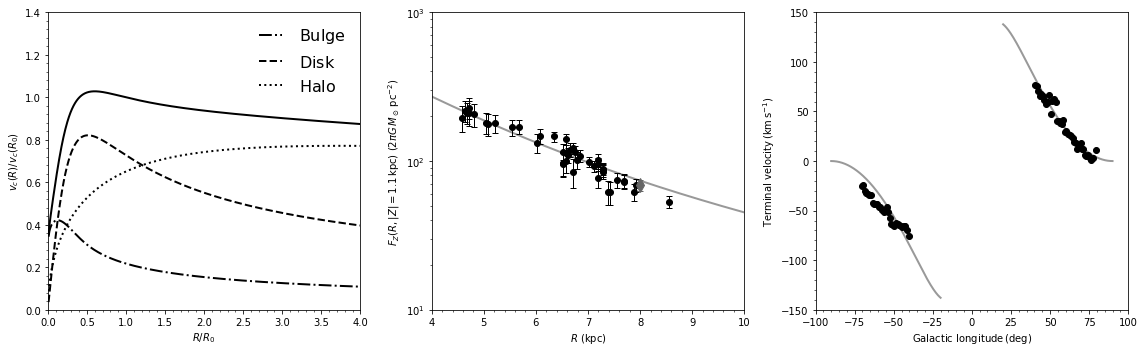

In [9]:
figsize(16,5)
p_b15_cp5= fit(fitc=False,c=0.5)

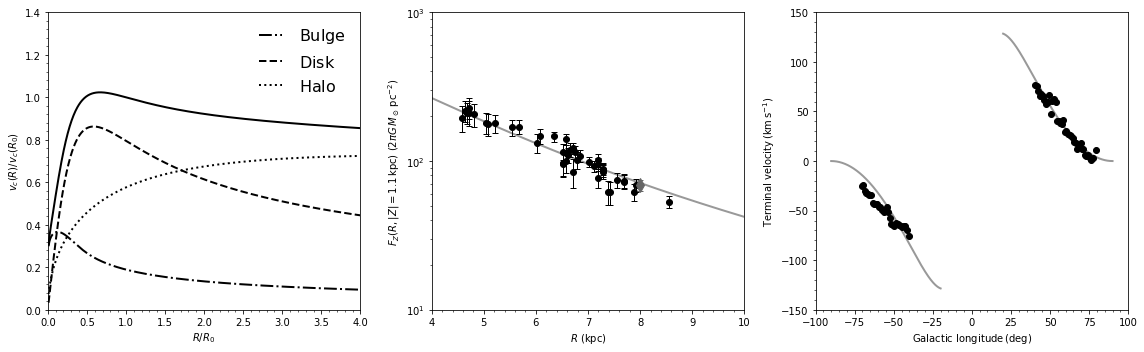

In [10]:
figsize(16,5)
p_b15_c1p5= fit(fitc=False,c=1.5)

All look pretty similar...

In [11]:
bf_savefilename= 'mwpot14varyc-bf.pkl'
if os.path.exists(bf_savefilename):
    with open(bf_savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        bf_params= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,4.1,0.1)
    bf_params= []
    for c in tqdm(cs):
        dum= fit(fitc=False,c=c)
        bf_params.append(dum[0])
    save_pickles(bf_savefilename,cs,bf_params)

## Fits with free $c$

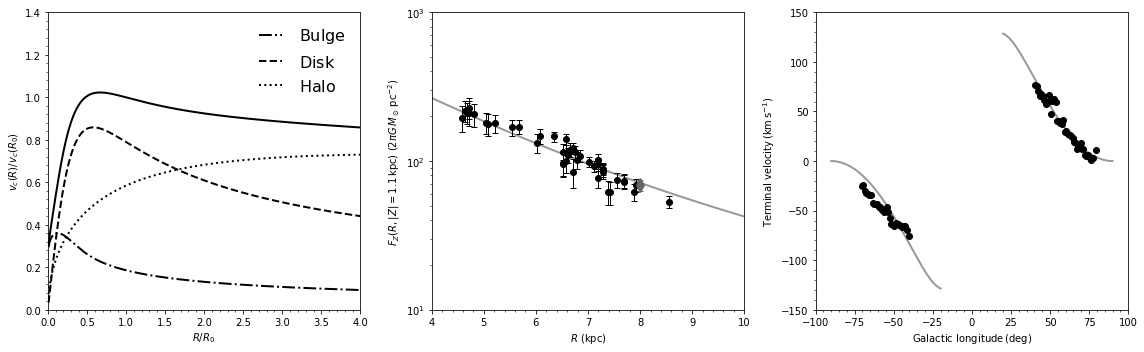

In [12]:
figsize(16,5)
p_b15_cfree= fit(fitc=True,c=None)

In [13]:
samples_savefilename = 'mwpot14varyc-samples.pkl'
if os.path.exists(samples_savefilename):
    with open(samples_savefilename,'rb') as savefile:
        s= pickle.load(savefile)
else:
    s = sample(nsamples= 100000,params=p_b15_cfree[0],fitc=True,c=None,plots=False, _use_emcee=True)
    save_pickles(samples_savefilename, s)

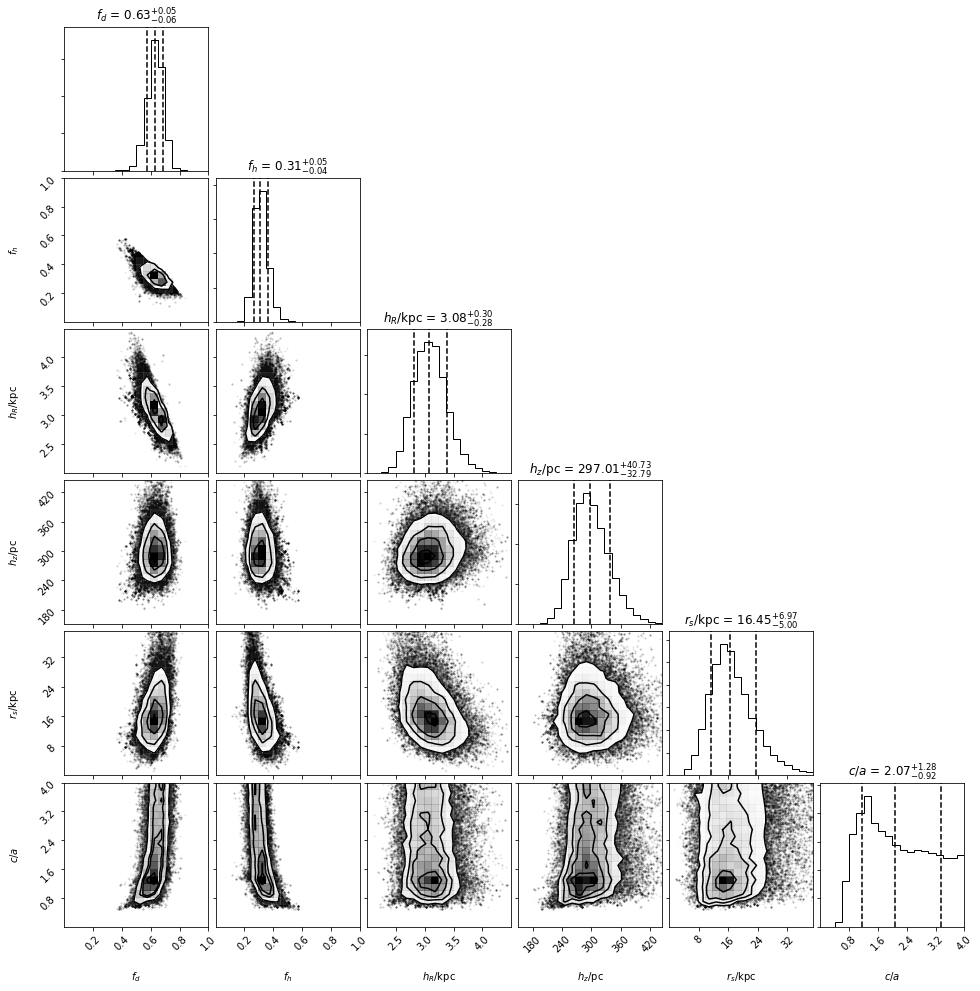

In [14]:
plot_samples(s,True,False)

Nice plot of the $c$ dependence of the other quantities

/home/nstarkman/local/galpy/galpy/util/bovy_plot.py:644: UserWarning: The following kwargs were not used by contour: 'aspect'
  linestyles=cntrls,origin=origin)



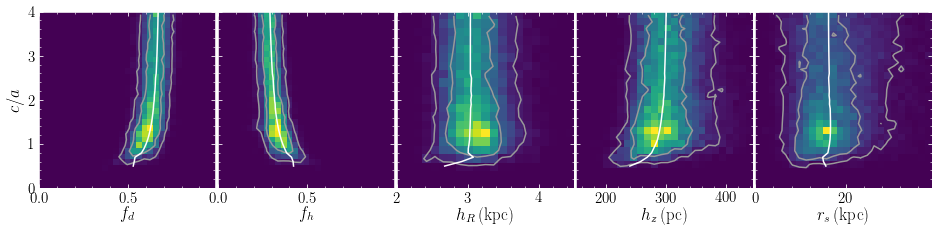

In [15]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
plot_mcmc_c(s,False)

/home/nstarkman/local/galpy/galpy/util/bovy_plot.py:166: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  out= pyplot.hist(x,**kwargs)

2.5% and 0.5% lower limits: 0.75, 0.62


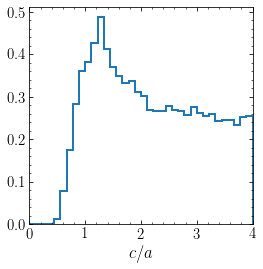

In [16]:
figsize(4,4)
dum= bovy_plot.bovy_hist(s[7],bins=36,histtype='step',lw=2.,
                        xlabel=r'$c/a$',xrange=[0.,4.],normed=True)
sortedc= numpy.array(sorted(s[7]))
print("2.5%% and 0.5%% lower limits: %.2f, %.2f" % \
    (sortedc[int(numpy.floor(0.025*len(sortedc)))],
     sortedc[int(numpy.floor(0.005*len(sortedc)))]))

### Also fitting $R_0$ and $V_c(R_0)$

/home/nstarkman/miniconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1977: RuntimeWarning: overflow encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)



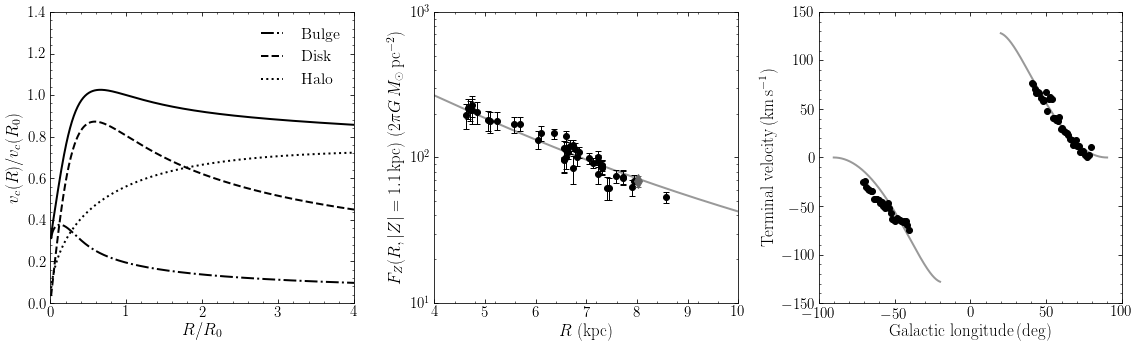

In [17]:
figsize(16,5)
p_b15_voro= fit(fitc=True,c=None,fitvoro=True)

In [18]:
samples_savefilename= 'mwpot14varyc-fitvoro-samples.pkl'
if os.path.exists(samples_savefilename):
    with open(samples_savefilename,'rb') as savefile:
        s= pickle.load(savefile)
else:
    s= sample(nsamples= 100000,params=p_b15_voro[0],fitc=True,c=None,plots=False,
              fitvoro=True)
    save_pickles(samples_savefilename,s)

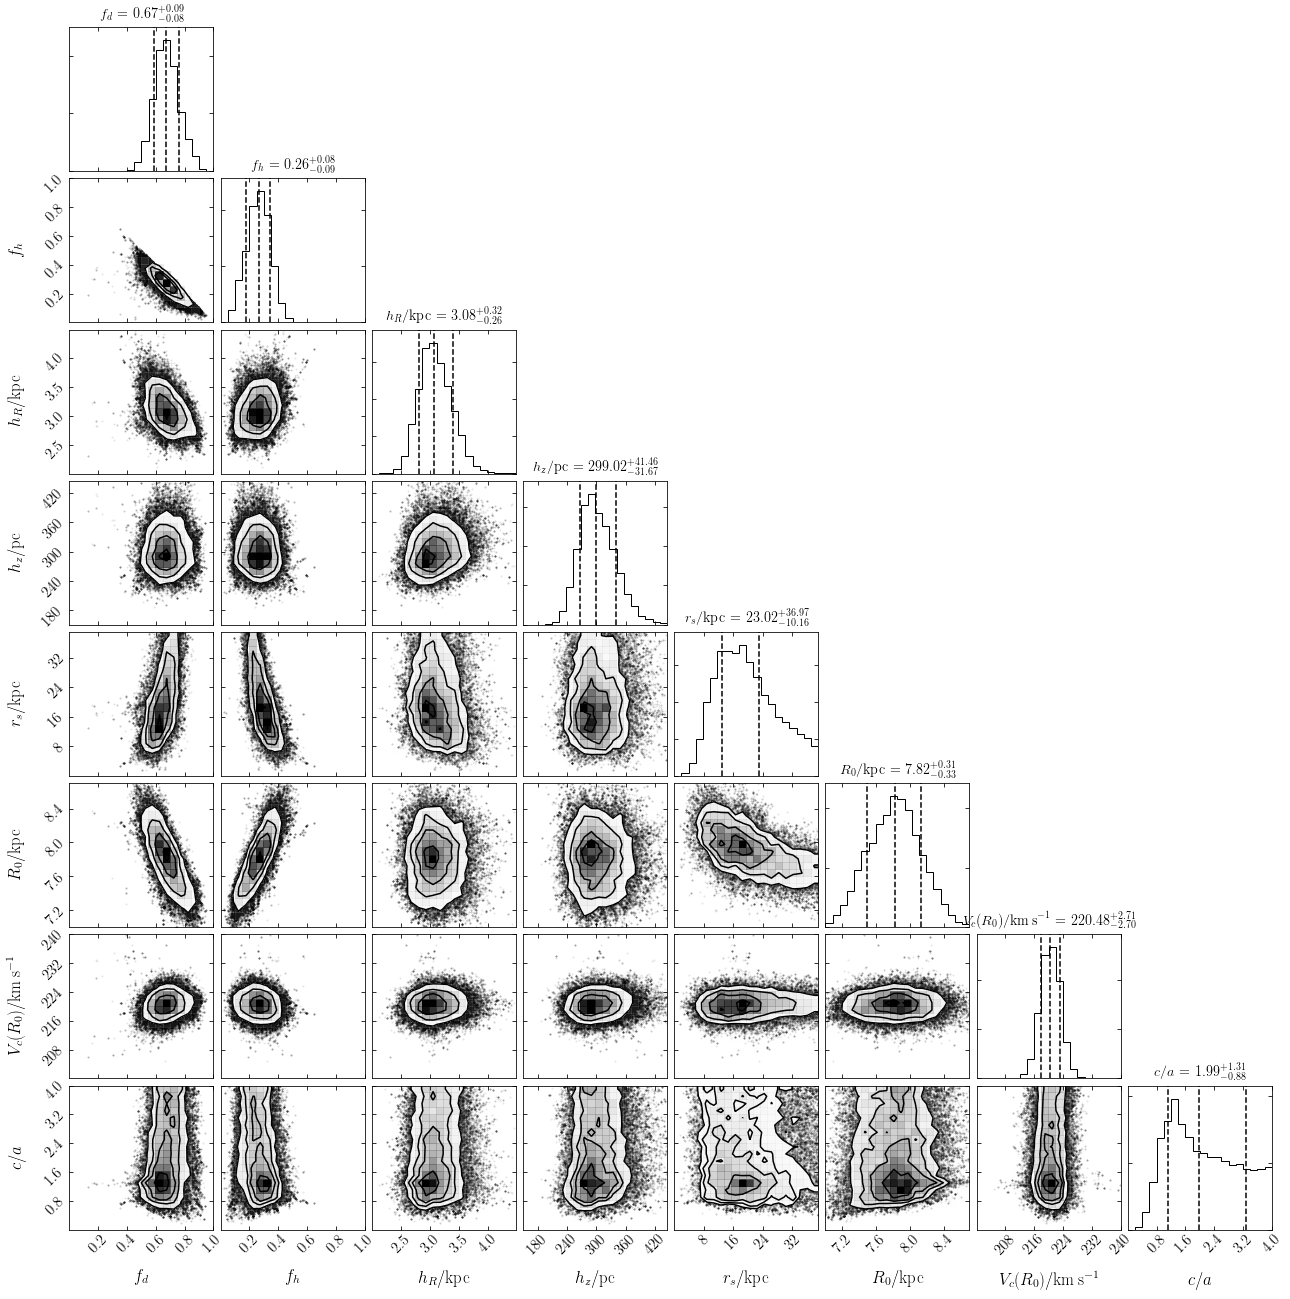

In [19]:
plot_samples(s,True,True)

/home/nstarkman/local/galpy/galpy/util/bovy_plot.py:644: UserWarning: The following kwargs were not used by contour: 'aspect'
  linestyles=cntrls,origin=origin)



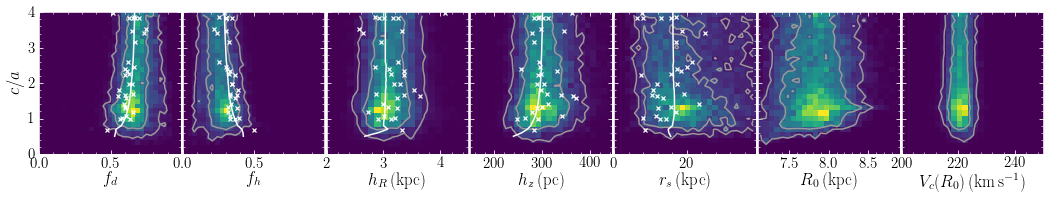

In [20]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
plot_mcmc_c(s,True,True)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-mwhalo-shape','mwpot14-varyc.pdf'),
                bbox_inches='tight')

/home/nstarkman/local/galpy/galpy/util/bovy_plot.py:166: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  out= pyplot.hist(x,**kwargs)

2.5% and 0.5% lower limits: 0.68, 0.48


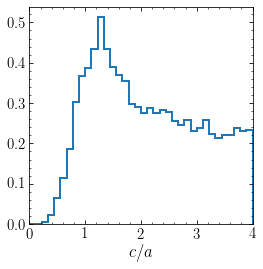

In [21]:
figsize(4,4)
dum= bovy_plot.bovy_hist(s[9],bins=36,histtype='step',lw=2.,
                        xlabel=r'$c/a$',xrange=[0.,4.],normed=True)
sortedc= numpy.array(sorted(s[9]))
print("2.5%% and 0.5%% lower limits: %.2f, %.2f" % \
    (sortedc[int(numpy.floor(0.025*len(sortedc)))],
     sortedc[int(numpy.floor(0.005*len(sortedc)))]))

## Using an exponential disk instead of a Miyamoto-Nagai disk

$c=1$:

In [ ]:
figsize(16,5)
p_exp= fit(fitc=False,c=1.,dblexp=True)

$c=0.5$:

In [ ]:
figsize(16,5)
p_exp_cp5= fit(fitc=False,c=0.5,dblexp=True)

$c=1.5$:

In [ ]:
figsize(16,5)
p_exp_c1p5= fit(fitc=False,c=1.5,dblexp=True)

Leave $c$ free:

In [ ]:
figsize(16,5)
p_exp_cfree= fit(fitc=True,c=None,dblexp=True)

In [ ]:
bf_savefilename= 'mwpot14varyc-dblexp-bf.pkl'
if os.path.exists(bf_savefilename):
    with open(bf_savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        bf_params= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,4.1,0.1)
    bf_params= []
    for c in tqdm(cs):
        dum= fit(fitc=False,c=c,dblexp=True,plots=False)
        bf_params.append(dum[0])
    save_pickles(bf_savefilename,cs,bf_params)

In [ ]:
samples_savefilename= 'mwpot14varyc-dblexp-samples.pkl'
if os.path.exists(samples_savefilename):
    with open(samples_savefilename,'rb') as savefile:
        s= pickle.load(savefile)
else:
    s= sample(nsamples=100000,params=p_exp_cfree[0],fitc=True,c=None,plots=False,dblexp=True)
    save_pickles(samples_savefilename,s)

In [ ]:
plot_samples(s,True,False)

In [ ]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
plot_mcmc_c(s,False)

In [ ]:
figsize(4,4)
dum= bovy_plot.bovy_hist(s[7],bins=36,histtype='step',lw=2.,
                        xlabel=r'$c/a$',xrange=[0.,4.],normed=True)
sortedc= numpy.array(sorted(s[7]))
print "2.5%% and 0.5%% lower limits: %.2f, %.2f" % \
    (sortedc[int(numpy.floor(0.025*len(sortedc)))],
     sortedc[int(numpy.floor(0.005*len(sortedc)))])

### Also fitting $R_0$ and $V_c(R_0)$

In [ ]:
figsize(16,5)
p_exp_cfree_voro= fit(fitc=True,c=None,dblexp=True,fitvoro=True)

In [ ]:
samples_savefilename= 'mwpot14varyc-dblexp-fitvoro-samples.pkl'
if os.path.exists(samples_savefilename):
    with open(samples_savefilename,'rb') as savefile:
        s= pickle.load(savefile)
else:
    s= sample(nsamples=100000,params=p_exp_cfree_voro[0],fitc=True,c=None,plots=False,
              dblexp=True,fitvoro=True)
    save_pickles(samples_savefilename,s)

In [ ]:
plot_samples(s,True,True)

In [ ]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
plot_mcmc_c(s,True)

In [ ]:
figsize(4,4)
dum= bovy_plot.bovy_hist(s[9],bins=36,histtype='step',lw=2.,
                        xlabel=r'$c/a$',xrange=[0.,4.],normed=True)
sortedc= numpy.array(sorted(s[9]))
print "2.5%% and 0.5%% lower limits: %.2f, %.2f" % \
    (sortedc[int(numpy.floor(0.025*len(sortedc)))],
     sortedc[int(numpy.floor(0.005*len(sortedc)))])

### Also adding in a gas disk (and still also fitting $R_0$ and $V_c(R_0)$)

In [ ]:
figsize(16,5)
p_exp_cfree_voro_wgas= fit(fitc=True,c=None,dblexp=True,fitvoro=True,addgas=True)

In [ ]:
samples_savefilename= 'mwpot14varyc-dblexp-fitvoro-addgas-samples.pkl'
if os.path.exists(samples_savefilename):
    with open(samples_savefilename,'rb') as savefile:
        s= pickle.load(savefile)
else:
    s= sample_multi(nsamples=100000,params=p_exp_cfree_voro_wgas[0],fitc=True,c=None,plots=False,
                  dblexp=True,fitvoro=True,addgas=True)
    save_pickles(samples_savefilename,s)

In [ ]:
plot_samples(s,True,True)

In [ ]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
plot_mcmc_c(s,True)

In [ ]:
figsize(4,4)
dum= bovy_plot.bovy_hist(s[9],bins=36,histtype='step',lw=2.,
                        xlabel=r'$c/a$',xrange=[0.,4.],normed=True)
sortedc= numpy.array(sorted(s[9]))
print "2.5%% and 0.5%% lower limits: %.2f, %.2f" % \
    (sortedc[int(numpy.floor(0.025*len(sortedc)))],
     sortedc[int(numpy.floor(0.005*len(sortedc)))])

## Adding in the force measurements from Pal 5; also fitting $R_0$ and $V_c(R_0)$

In [ ]:
figsize(16,5)
p_b15_pal5_voro= fit(fitc=True,c=None,addpal5=True,fitvoro=True,mc16=True)

In [ ]:
samples_savefilename= 'mwpot14varyc-fitvoro-pal5-samples.pkl'
if os.path.exists(samples_savefilename):
    with open(samples_savefilename,'rb') as savefile:
        s= pickle.load(savefile)
else:
    s= sample(nsamples=100000,params=p_b15_pal5_voro[0],fitc=True,c=None,plots=False,
              addpal5=True,fitvoro=True)
    save_pickles(samples_savefilename,s)

In [ ]:
plot_samples(s,True,True,addpal5=True)

In [ ]:
bf_savefilename= 'mwpot14varyc-bf.pkl'
if os.path.exists(bf_savefilename):
    with open(bf_savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        bf_params= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,4.1,0.1)
    bf_params= []
    for c in tqdm(cs):
        dum= fit(fitc=False,c=c)
        bf_params.append(dum[0])
    save_pickles(bf_savefilename,cs,bf_params)

In [ ]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
plot_mcmc_c(s,True)

In [ ]:
figsize(4,4)
cindx= 9
dum= bovy_plot.bovy_hist(s[cindx],bins=36,histtype='step',lw=2.,
                        xlabel=r'$c/a$',xrange=[0.5,1.5],normed=True)
sortedc= numpy.array(sorted(s[cindx]))
print "2.5%% and 0.5%% lower limits: %.2f, %.2f" % \
    (sortedc[int(numpy.floor(0.025*len(sortedc)))],
     sortedc[int(numpy.floor(0.005*len(sortedc)))])
print "2.5%% and 0.5%% upper limits: %.2f, %.2f" % \
    (sortedc[int(numpy.floor(0.975*len(sortedc)))],
     sortedc[int(numpy.floor(0.995*len(sortedc)))])
print "Median, 68%% confidence: %.2f, %.2f, %.2f" % \
    (numpy.median(sortedc),
     sortedc[int(numpy.floor(0.16*len(sortedc)))],
     sortedc[int(numpy.floor(0.84*len(sortedc)))])

## Adding in the force measurements from GD-1; also fitting $R_0$ and $V_c(R_0)$

In [ ]:
figsize(16,5)
p_b15_gd1_voro= fit(fitc=True,c=None,addgd1=True,fitvoro=True,mc16=True)

In [ ]:
samples_savefilename= 'mwpot14varyc-fitvoro-gd1-samples.pkl'
if os.path.exists(samples_savefilename):
    with open(samples_savefilename,'rb') as savefile:
        s= pickle.load(savefile)
else:
    s= sample(nsamples=100000,params=p_b15_gd1_voro[0],fitc=True,c=None,plots=False,
              addgd1=True,fitvoro=True)
    save_pickles(samples_savefilename,s)

In [ ]:
plot_samples(s,True,True,addgd1=True)

In [ ]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
plot_mcmc_c(s,True)

In [ ]:
figsize(4,4)
cindx= 9
dum= bovy_plot.bovy_hist(s[cindx],bins=36,histtype='step',lw=2.,
                        xlabel=r'$c/a$',xrange=[0.5,2.5],normed=True)
sortedc= numpy.array(sorted(s[cindx]))
print "2.5%% and 0.5%% lower limits: %.2f, %.2f" % \
    (sortedc[int(numpy.floor(0.025*len(sortedc)))],
     sortedc[int(numpy.floor(0.005*len(sortedc)))])
print "2.5%% and 0.5%% upper limits: %.2f, %.2f" % \
    (sortedc[int(numpy.floor(0.975*len(sortedc)))],
     sortedc[int(numpy.floor(0.995*len(sortedc)))])
print "Median, 68%% confidence: %.2f, %.2f, %.2f" % \
    (numpy.median(sortedc),
     sortedc[int(numpy.floor(0.16*len(sortedc)))],
     sortedc[int(numpy.floor(0.84*len(sortedc)))])

## Adding in the force measurements from Pal 5 *and* GD-1; also fitting $R_0$ and $V_c(R_0)$

In [ ]:
figsize(16,5)
p_b15_pal5gd1_voro= fit(fitc=True,c=None,addpal5=True,addgd1=True,fitvoro=True,mc16=True)

In [ ]:
samples_savefilename= 'mwpot14varyc-fitvoro-pal5gd1-samples.pkl'
if os.path.exists(samples_savefilename):
    with open(samples_savefilename,'rb') as savefile:
        s= pickle.load(savefile)
else:
    s= sample(nsamples= 100000,params=p_b15_pal5gd1_voro[0],fitc=True,c=None,plots=False,
              mc16=True,addpal5=True,addgd1=True,fitvoro=True)
    save_pickles(samples_savefilename,s)

In [ ]:
plot_samples(s,True,True,addpal5=True,addgd1=True)

In [ ]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
plot_mcmc_c(s,True)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-mwhalo-shape','mwpot14-varyc-wp5g1.pdf'),bbox_inches='tight')

In [ ]:
figsize(4,4)
cindx= 9
dum= bovy_plot.bovy_hist(s[cindx],bins=36,histtype='step',lw=2.,
                        xlabel=r'$c/a$',xrange=[0.5,1.5],normed=True)
sortedc= numpy.array(sorted(s[cindx][-50000:]))
print "2.5%% and 0.5%% lower limits: %.3f, %.3f" % \
    (sortedc[int(numpy.floor(0.025*len(sortedc)))],
     sortedc[int(numpy.floor(0.005*len(sortedc)))])
print "2.5%% and 0.5%% upper limits: %.3f, %.3f" % \
    (sortedc[int(numpy.floor(0.975*len(sortedc)))],
     sortedc[int(numpy.floor(0.995*len(sortedc)))])
print "Median, 68%% confidence: %.3f, %.3f, %.3f" % \
    (numpy.median(sortedc),
     sortedc[int(numpy.floor(0.16*len(sortedc)))],
     sortedc[int(numpy.floor(0.84*len(sortedc)))])
print "Mean, std. dev.: %.2f,%.2f" % \
    (numpy.mean(sortedc),numpy.std(sortedc))

What is the constraint on the mass of the halo?

In [ ]:
tR= 20./_REFR0
skip= 1
hmass= []
for sa in tqdm(s.T[::skip]):
    pot= MWPotential2014Likelihood.setup_potential(sa,sa[-1],True,False,_REFR0*sa[8],_REFV0*sa[7],fitvoro=True)
    hmass.append(-integrate.quad(lambda x: tR**2.*potential.evaluaterforces(pot[2],tR*x,\
                    tR*numpy.sqrt(1.-x**2.),phi=0.),0.,1.)[0]\
                           *bovy_conversion.mass_in_1010msol(_REFV0,_REFR0)/10.)
hmass= numpy.array(hmass)
sortedhm= numpy.array(sorted(hmass))
print "2.5%% and 0.5%% lower limits: %.2f, %.2f" % \
    (sortedhm[int(numpy.floor(0.025*len(sortedhm)))],
     sortedhm[int(numpy.floor(0.005*len(sortedhm)))])
print "2.5%% and 0.5%% upper limits: %.2f, %.2f" % \
    (sortedhm[int(numpy.floor(0.975*len(sortedhm)))],
     sortedhm[int(numpy.floor(0.995*len(sortedhm)))])
print "Median, 68%% confidence: %.2f, %.2f, %.2f" % \
    (numpy.median(sortedhm),
     sortedhm[int(numpy.floor(0.16*len(sortedhm)))],
     sortedhm[int(numpy.floor(0.84*len(sortedhm)))])

In [ ]:
bovy_plot.scatterplot(hmass,s[-1,::skip],'k,',
                      onedhists=True,bins=31,
                      xrange=[0.5,1.5],yrange=[0.5,1.5],
                      xlabel=r'$M_{\mathrm{halo}} (r<20\,\mathrm{kpc})\,(M_\odot)$',
                      ylabel=r'$c/a$')

## Adding in the force measurements from Pal 5 *and* GD-1; also fitting $R_0$ and $V_c(R_0)$; using a double-exponential disk model

In [ ]:
figsize(16,5)
p_b15_pal5gd1_voro_dblexp= fit(fitc=True,c=None,addpal5=True,addgd1=True,fitvoro=True,mc16=True,dblexp=True)

In [ ]:
samples_savefilename= 'mwpot14varyc-fitvoro-pal5gd1-dblexp-samples.pkl'
if os.path.exists(samples_savefilename):
    with open(samples_savefilename,'rb') as savefile:
        s= pickle.load(savefile)
else:
    s= sample(nsamples= 100000,params=p_b15_pal5gd1_voro_dblexp[0],fitc=True,c=None,plots=False,
              mc16=True,addpal5=True,addgd1=True,fitvoro=True,dblexp=True)
    save_pickles(samples_savefilename,s)

In [ ]:
plot_samples(s,True,True,addpal5=True,addgd1=True)

In [ ]:
bf_savefilename= 'mwpot14varyc-dblexp-bf.pkl'
if os.path.exists(bf_savefilename):
    with open(bf_savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        bf_params= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,4.1,0.1)
    bf_params= []
    for c in tqdm(cs):
        dum= fit(fitc=False,c=c,dblexp=True,plots=False)
        bf_params.append(dum[0])
    save_pickles(bf_savefilename,cs,bf_params)

In [ ]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
plot_mcmc_c(s,True)

In [ ]:
figsize(4,4)
cindx= 9
dum= bovy_plot.bovy_hist(s[cindx],bins=36,histtype='step',lw=2.,
                        xlabel=r'$c/a$',xrange=[0.5,1.5],normed=True)
sortedc= numpy.array(sorted(s[cindx][-50000:]))
print "2.5%% and 0.5%% lower limits: %.2f, %.2f" % \
    (sortedc[int(numpy.floor(0.025*len(sortedc)))],
     sortedc[int(numpy.floor(0.005*len(sortedc)))])
print "2.5%% and 0.5%% upper limits: %.2f, %.2f" % \
    (sortedc[int(numpy.floor(0.975*len(sortedc)))],
     sortedc[int(numpy.floor(0.995*len(sortedc)))])
print "Median, 68%% confidence: %.2f, %.2f, %.2f" % \
    (numpy.median(sortedc),
     sortedc[int(numpy.floor(0.16*len(sortedc)))],
     sortedc[int(numpy.floor(0.84*len(sortedc)))])
print "Mean, std. dev.: %.2f,%.2f" % \
    (numpy.mean(sortedc),numpy.std(sortedc))

What is the constraint on the mass of the halo?

In [ ]:
from scipy import integrate
tR= 20./_REFR0
skip= 1
hmass= []
for sa in tqdm(s.T[::skip]):
    pot= MWPotential2014Likelihood.setup_potential(sa,sa[-1],True,False,_REFR0*sa[8],_REFV0*sa[7],fitvoro=True)
    hmass.append(-integrate.quad(lambda x: tR**2.*potential.evaluaterforces(pot[2],tR*x,\
                    tR*numpy.sqrt(1.-x**2.),phi=0.),0.,1.)[0]\
                           *bovy_conversion.mass_in_1010msol(_REFV0,_REFR0)/10.)
hmass= numpy.array(hmass)
sortedhm= numpy.array(sorted(hmass))
print "2.5%% and 0.5%% lower limits: %.2f, %.2f" % \
    (sortedhm[int(numpy.floor(0.025*len(sortedhm)))],
     sortedhm[int(numpy.floor(0.005*len(sortedhm)))])
print "2.5%% and 0.5%% upper limits: %.2f, %.2f" % \
    (sortedhm[int(numpy.floor(0.975*len(sortedhm)))],
     sortedhm[int(numpy.floor(0.995*len(sortedhm)))])
print "Median, 68%% confidence: %.2f, %.2f, %.2f" % \
    (numpy.median(sortedhm),
     sortedhm[int(numpy.floor(0.16*len(sortedhm)))],
     sortedhm[int(numpy.floor(0.84*len(sortedhm)))])

In [ ]:
bovy_plot.scatterplot(hmass,s[-1,::skip],'k,',
                      onedhists=True,bins=31,
                      xrange=[0.5,1.5],yrange=[0.5,1.5],
                      xlabel=r'$M_{\mathrm{halo}} (r<20\,\mathrm{kpc})\,(M_\odot)$',
                      ylabel=r'$c/a$')

## Adding in the force measurements from Pal 5 *and* GD-1; also fitting $R_0$ and $V_c(R_0)$; using a double-exponential disk model and a gas component

In [ ]:
figsize(16,5)
p_b15_pal5gd1_voro_dblexp_wgas= fit(fitc=True,c=None,addpal5=True,addgd1=True,fitvoro=True,
                                    mc16=True,dblexp=True,addgas=True)

In [ ]:
samples_savefilename= 'mwpot14varyc-fitvoro-pal5gd1-dblexp-addgas-samples.pkl'
if os.path.exists(samples_savefilename):
    with open(samples_savefilename,'rb') as savefile:
        s= pickle.load(savefile)
else:
    s= sample_multi(nsamples=100000,params=p_b15_pal5gd1_voro_dblexp_wgas[0],fitc=True,c=None,plots=False,
                    mc16=True,addpal5=True,addgd1=True,fitvoro=True,dblexp=True,addgas=True)
    save_pickles(samples_savefilename,s)

In [ ]:
plot_samples(s,True,True,addpal5=True,addgd1=True)

In [ ]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
plot_mcmc_c(s,True)

In [ ]:
figsize(4,4)
cindx= 9
dum= bovy_plot.bovy_hist(s[cindx],bins=36,histtype='step',lw=2.,
                        xlabel=r'$c/a$',xrange=[0.5,1.5],normed=True)
sortedc= numpy.array(sorted(s[cindx][-50000:]))
print "2.5%% and 0.5%% lower limits: %.2f, %.2f" % \
    (sortedc[int(numpy.floor(0.025*len(sortedc)))],
     sortedc[int(numpy.floor(0.005*len(sortedc)))])
print "2.5%% and 0.5%% upper limits: %.2f, %.2f" % \
    (sortedc[int(numpy.floor(0.975*len(sortedc)))],
     sortedc[int(numpy.floor(0.995*len(sortedc)))])
print "Median, 68%% confidence: %.2f, %.2f, %.2f" % \
    (numpy.median(sortedc),
     sortedc[int(numpy.floor(0.16*len(sortedc)))],
     sortedc[int(numpy.floor(0.84*len(sortedc)))])
print "Mean, std. dev.: %.2f,%.2f" % \
    (numpy.mean(sortedc),numpy.std(sortedc))

# The Milky Way's force field

Let's make a plot of the Milky Way's force field in the best-fit potential, with measurements indicated

In [ ]:
# Set up potential
p_b15= p_b15_pal5gd1_voro[0]
ro,vo= _REFR0,_REFV0
pot= MWPotential2014Likelihood.setup_potential(p_b15,p_b15_pal5gd1_voro[0][-1],
                                               False,False,ro,vo)
# Compute force field
Rs= numpy.linspace(0.01,20.,51)
zs= numpy.linspace(-20.,20.,151)
mRs, mzs= numpy.meshgrid(Rs,zs,indexing='ij')
forces= numpy.zeros((len(Rs),len(zs),2))
potvals= numpy.zeros((len(Rs),len(zs)))
for ii in tqdm(range(len(Rs))):
    for jj in tqdm(range(len(zs))):
        forces[ii,jj,0]= potential.evaluateRforces(pot,mRs[ii,jj]/ro,mzs[ii,jj]/ro,use_physical=True,ro=ro,vo=vo)
        forces[ii,jj,1]= potential.evaluatezforces(pot,mRs[ii,jj]/ro,mzs[ii,jj]/ro,use_physical=True,ro=ro,vo=vo)
        potvals[ii,jj]= potential.evaluatePotentials(pot,mRs[ii,jj]/ro,mzs[ii,jj]/ro,use_physical=True,ro=ro,vo=vo)

In [ ]:
figsize(8,16)
skip= 10 # Make sure to keep zs symmetric!!
scale= 35.
# Don't plot these
#forces[(mRs < 5.)*(numpy.fabs(mzs) < 4.)]= numpy.nan
forces[(mRs < 2.)*(numpy.fabs(mzs) < 5.)]= numpy.nan
bovy_plot.bovy_dens2d(potvals.T,origin='lower',cmap='viridis',
                      xrange=[Rs[0],Rs[-1]],
                      yrange=[zs[0],zs[-1]],
                      xlabel=r'$R\,(\mathrm{kpc})$',
                      ylabel=r'$Z\,(\mathrm{kpc})$',
                     contours=True,aspect=1.)
quiver(mRs[1::skip,5:-1:skip],mzs[1::skip,5:-1:skip],
       forces[1::skip,5:-1:skip,0],
       forces[1::skip,5:-1:skip,1],scale=scale)
# Add a few lines pointing to the GC
for angle in tqdm(numpy.linspace(0.,numpy.pi/2.,8)):
    plot((0.,100.*numpy.cos(angle)),(0.,100.*numpy.sin(angle)),'k:')
    plot((0.,100.*numpy.cos(angle)),(0.,-100.*numpy.sin(angle)),'k:')
# Add measurements
# Pal 5
quiver((8.,),(16.,),(-0.8,),(-1.82,),color='w',zorder=10,scale=scale)
# GD-1
quiver((12.5,),(6.675,),(-2.51,),(-1.47,),color='w',zorder=10,scale=scale)
# Disk + flat APOGEE rotation curve: 
# Use Bovy & Tremaine (2012) method for translating F_R in the plane to F_R at 1.1 kpc: dFr/dz = dFz / dR
diskrs= numpy.linspace(5.5,8.5,3)
diskfzs= -67.*numpy.exp(-(diskrs-8.)/2.7)\
    /bovy_conversion.force_in_2piGmsolpc2(220.,8.)*bovy_conversion.force_in_kmsMyr(220.,8.)
diskfrs= -(218.**2./diskrs)*bovy_conversion._kmsInPcMyr/1000.-1.1*diskfzs/2.7
quiver(diskrs,1.1*numpy.ones_like(diskrs),diskfrs,diskfzs,color='w',zorder=10,scale=scale)
# Labels
bovy_plot.bovy_text(5.8,16.,r'$\mathbf{Pal\ 5}$',color='w',size=17.)
bovy_plot.bovy_text(12.5,7.,r'$\mathbf{GD-1}$',color='w',size=17.)
bovy_plot.bovy_text(8.65,.5,r'$\mathbf{disk\ stars}$',color='w',size=17.)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-mwhalo-shape','forcefield.pdf'),
                bbox_inches='tight')

In [ ]:
zs= numpy.linspace(-20.,20.,151)
skip= 10
zs[5:-1:skip]